In [2]:
import pandas as pd
import numpy as np

import altair as alt
import hela.visualization.hmm as hmmplot
import matplotlib.pyplot as plt
%matplotlib inline

from hela import hmm
import hela.generation.hmm as gen
from scipy.special import logsumexp

from datetime import datetime
from dask.distributed import Client

TU_COLORS = [
    "#9b67ff", "#57b3c2", "#ffa040", "#ff6283", "#2ccc72", "#1270cb", "#bd043a",
    "#a1c54d", "#4c319e", "#c6c0fe", "#195036", "#f6a39f"
]

In [4]:
generative_model = gen.DiscreteHMMGenerativeModel(
                                     n_hidden_states =3,
                                     n_gaussian_features=2,
                                    n_categorical_features = 1,
                                     n_gmm_components = 1)

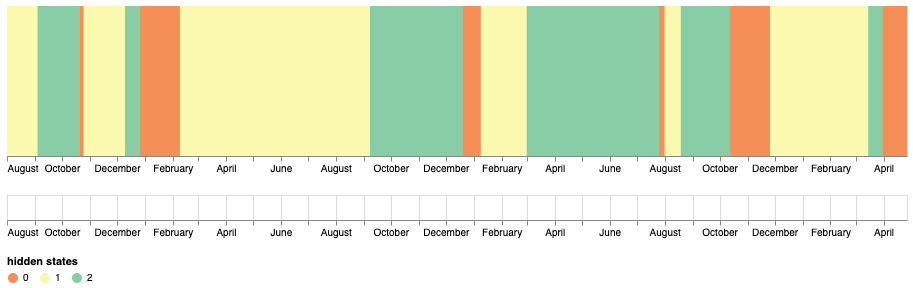

In [6]:
hidden_states = generative_model.generate_hidden_state_sequence(n_observations = 1000)
hmmplot.draw_states(hidden_states, hide_brush=False)

In [7]:
hmm_data = generative_model.generate_observations(hidden_states)
hmm_data.head()

,categorical_feature_0,gaussian_feature_0,gaussian_feature_1
2020-08-01,1,-4.354029,-4.934901
2020-08-02,1,-3.886656,-4.466785
2020-08-03,1,-2.766977,-5.135750
2020-08-04,1,-0.528518,-5.316106
2020-08-05,1,-3.003749,-4.931316


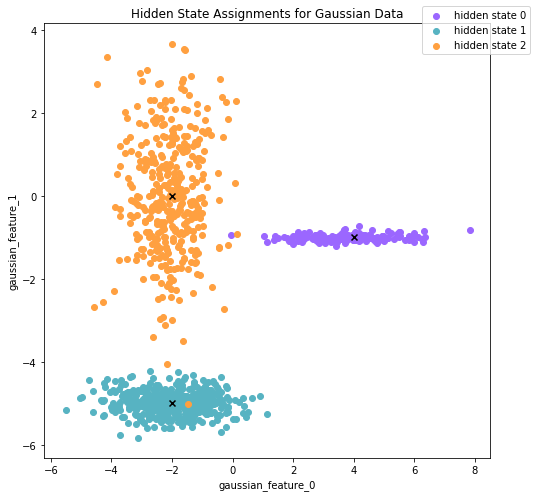

In [8]:
def plot_hidden_states(data, hidden_states,means, title):
    plt.figure(figsize = (8,8))
    for i in range(generative_model.n_hidden_states):
        idx = data[hidden_states == i].index
        plt.scatter(data.loc[idx,'gaussian_feature_0'], 
                    data.loc[idx,'gaussian_feature_1'], 
                    color = TU_COLORS[i],
                    label = "hidden state {}".format(i))
    for i in range(len(means)):
        plt.scatter(means[i][0][0], 
                    means[i][0][1], 
                    color = "black", 
                    marker = "x")

    plt.legend(bbox_to_anchor=(1.1, 1.05))
    plt.xlabel('gaussian_feature_0')
    plt.ylabel('gaussian_feature_1')
    plt.title(title)
    plt.show()
    
plot_hidden_states(hmm_data,hidden_states,generative_model.means,"Hidden State Assignments for Gaussian Data")

In [27]:
# training_spec = gen.data_to_discrete_hmm_training_spec(hidden_states=hidden_states, 
#                                        n_hidden_states=generative_model.n_hidden_states, 
#                                        data=hmm_data, 
#                                        categorical_features = None,#list(generative_model.categorical_values.columns),
#                                        gaussian_features=list(generative_model.gaussian_values.columns),
#                                        n_gmm_components=1)

hidden_states=hidden_states
n_hidden_states=generative_model.n_hidden_states
data=hmm_data
categorical_features = list(generative_model.categorical_values.columns)
gaussian_features=list(generative_model.gaussian_values.columns)
n_gmm_components=1

In [28]:
import itertools
spec = {"hidden_state": {"type": "finite", "count": n_hidden_states}}
# spec = {"hidden_state": {"type": "finite", "count": ns_hidden_states}}
observations = []
if categorical_features:
    categorical_features.sort()
    categorical_values = []
for feat in categorical_features:
    values = list(data[feat].unique())
    values.sort()
    observations.append({
                "name": feat,
                "type": "finite",
                "values": values
            })
    categorical_values.append(values)
    value_tuples = list(itertools.product(*categorical_values))
if gaussian_features:
    gaussian_features.sort()
    for feat in gaussian_features:
            observations.append({
                "name": feat,
                "type": "continuous",
                "dist": "gaussian",
                "dims": 1
            })
spec["observations"] = observations
        

In [33]:
model_parameter_constraints = {}
transition_matrix = np.zeros((n_hidden_states, n_hidden_states))

# transition_matrices = []
# for n in factored_generative_model.ns_hidden_states:
#     transition_matrix = np.zeros((n, n))
#     transition_matrices.append(transition_matrix)
# transition_matrices = np.array(transition_matrices)

# for i in factored_hidden_states.columns:
#     transition_matrix = transition_matrices[i]
#     for j in range(factored_hidden_states[i].shape[0]-1):
#         current_state = factored_hidden_states[i][j]
#         next_state = factored_hidden_states[i][j+1]
#         if ~np.isnan(current_state) and ~np.isnan(next_state):
#             transition_matrix[int(current_state)][int(next_state)] += 1
#     for k in range(factored_generative_model.ns_hidden_states[i]):
#         if np.sum(transition_matrix[k]) == 0:
#             transition_matrix[k] = np.full(ns_hidden_states[k], 1)
#     transition_matrix = transition_matrix / np.sum(transition_matrix, axis=1).reshape(-1, 1)
#     transition_matrices[i] = transition_matrix
# model_parameter_constraints["transition_constraints"] = transition_matrix

for i in range(hidden_states.shape[0] - 1):
    current_state = hidden_states[i]
    next_state = hidden_states[i + 1]
    if ~np.isnan(current_state) and ~np.isnan(next_state):
        transition_matrix[int(current_state)][int(next_state)] += 1
for i in range(n_hidden_states):
    if np.sum(transition_matrix[i]) == 0:
        transition_matrix[i] = np.full(n_hidden_states, 1)
transition_matrix = transition_matrix / np.sum(
    transition_matrix, axis=1).reshape(-1, 1)

model_parameter_constraints["transition_constraints"] = transition_matrix


In [40]:
# Construct initial state vector from hidden state sequence.
initial_state_vector = np.zeros(n_hidden_states)
if ~np.isnan(hidden_states[0]):
    initial_state_vector[int(hidden_states[0])] = 1
model_parameter_constraints[
    "initial_state_constraints"] = initial_state_vector

In [57]:
if categorical_features:
    value_tuple_dict = {str(list(v)): e for e, v in enumerate(value_tuples)}
    emissions = pd.Series(
        [
            value_tuple_dict[str(list(i))]
            for i in np.array(data[categorical_features])
        ],
        index=data.index)

    emission_matrix = np.zeros((emissions.nunique(), np.prod(ns_hidden_states)))
emission_matrix
#     for i in list(
#             set.intersection(
#                 set(hidden_states[~hidden_states.isna()].index),
#                 set(emissions.index))):
#         emission_matrix[emissions[i], int(hidden_states[i])] += 1

#     for i in range(n_hidden_states):
#         if np.sum([e[i] for e in emission_matrix]) == 0:
#             emission_matrix[:, i] = np.full(emission_matrix.shape[0], 1)
#     emission_matrix = emission_matrix / np.sum(emission_matrix, axis=0)
#     model_parameter_constraints["emission_constraints"] = emission_matrix
#     spec["model_parameter_constraints"] = model_parameter_constraints
# print(emission_matrix)

NameError: name 'ns_hidden_states' is not defined

In [ ]:
def data_to_discrete_hmm_training_spec(hidden_states, n_hidden_states, data,
                                       categorical_features, gaussian_features,
                                       n_gmm_components):
    """ Returns hmm training spec from hidden state sequence and data.

    Arguments:
        hidden_states: (series) of hidden states (typically) generated
                using generate_hidden_state_sequence(n_observations).
        n_hidden_states: (int) number of hidden states.
        data: (dataframe) data with the same index as the series
            hidden_states and columns corresponding to categorical_features
            and guassian_features.
        categorical_features: (list) of categorical features as strings.
        gaussian_features: (list) of gaussian features as strings.
        n_gmm_components: (int) number of gmm components per hidden state.

    Returns:
        Training spec dictionary informed by the hidden state
        sequence and the data which can be used as input in the
        hmm function `DiscreteHHHConfiguration.from_spec()`.
    """
    spec = {"hidden_state": {"type": "finite", "count": n_hidden_states}}
    observations = []
    if categorical_features:
        categorical_features.sort()
        categorical_values = []
        for feat in categorical_features:
            values = list(data[feat].unique())
            values.sort()
            observations.append({
                "name": feat,
                "type": "finite",
                "values": values
            })
            categorical_values.append(values)
        value_tuples = list(itertools.product(*categorical_values))
    if gaussian_features:
        gaussian_features.sort()
        for feat in gaussian_features:
            observations.append({
                "name": feat,
                "type": "continuous",
                "dist": "gaussian",
                "dims": 1
            })
    spec["observations"] = observations

    model_parameter_constraints = {}

    # Construct transition matrix from hidden state sequence.
    transition_matrix = np.zeros((n_hidden_states, n_hidden_states))
    for i in range(hidden_states.shape[0] - 1):
        current_state = hidden_states[i]
        next_state = hidden_states[i + 1]
        if ~np.isnan(current_state) and ~np.isnan(next_state):
            transition_matrix[int(current_state)][int(next_state)] += 1
    for i in range(n_hidden_states):
        if np.sum(transition_matrix[i]) == 0:
            transition_matrix[i] = np.full(n_hidden_states, 1)
    transition_matrix = transition_matrix / np.sum(
        transition_matrix, axis=1).reshape(-1, 1)
    model_parameter_constraints["transition_constraints"] = transition_matrix

    # Construct initial state vector from hidden state sequence.
    initial_state_vector = np.zeros(n_hidden_states)
    if ~np.isnan(hidden_states[0]):
        initial_state_vector[int(hidden_states[0])] = 1
        model_parameter_constraints[
            "initial_state_constraints"] = initial_state_vector

    # Construct emission matrix from hidden state sequence and data.
    if categorical_features:
        value_tuple_dict = {str(list(v)): e for e, v in enumerate(value_tuples)}
        emissions = pd.Series(
            [
                value_tuple_dict[str(list(i))]
                for i in np.array(data[categorical_features])
            ],
            index=data.index)
        emission_matrix = np.zeros((emissions.nunique(), n_hidden_states))
        for i in list(
                set.intersection(
                    set(hidden_states[~hidden_states.isna()].index),
                    set(emissions.index))):
            emission_matrix[emissions[i], int(hidden_states[i])] += 1
        for i in range(n_hidden_states):
            if np.sum([e[i] for e in emission_matrix]) == 0:
                emission_matrix[:, i] = np.full(emission_matrix.shape[0], 1)
        emission_matrix = emission_matrix / np.sum(emission_matrix, axis=0)
        model_parameter_constraints["emission_constraints"] = emission_matrix
        spec["model_parameter_constraints"] = model_parameter_constraints

    # Determine gmm parameter constraints from data.
    if gaussian_features:
        gmm_parameter_constraints = {}
        means = np.empty((n_hidden_states, n_gmm_components,
                          len(gaussian_features)))
        covariances = np.empty((n_hidden_states, n_gmm_components,
                                len(gaussian_features), len(gaussian_features)))
        component_weights = np.empty((n_hidden_states, n_gmm_components))
        for i in hidden_states[~hidden_states.isna()].unique():
            df = data.loc[hidden_states[hidden_states == i].index,
                          gaussian_features]
            if n_gmm_components == 1:
                means[int(i)] = np.mean(np.array(df), axis=0)
                covariances[int(i)] = np.array(
                    np.cov(np.array(df), rowvar=False))
                component_weights[int(i)] = np.array([1])
            if n_gmm_components > 1:
                gmm = mixture.GaussianMixture(
                    n_components=n_gmm_components, covariance_type="full")
                gmm.fit(df)
                means[int(i)] = gmm.means_
                covariances[int(i)] = gmm.covariances_
                component_weights[int(i)] = gmm.weights_
            gmm_parameter_constraints = {
                "n_gmm_components": n_gmm_components,
                "means": means,
                "covariances": covariances,
                "component_weights": component_weights
            }
        model_parameter_constraints[
            "gmm_parameter_constraints"] = gmm_parameter_constraints

    spec["model_parameter_constraints"] = model_parameter_constraints

    return spec